__Dudas__:
*  ¿Se debe aplicar la función a las series con o sin ceros?

In [1]:
import os
rutaBase = os.getcwd() + '\\'

In [2]:
import numpy as np
from datetime import datetime, timedelta
from statsmodels.distributions.empirical_distribution import ECDF

In [19]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid')
plt.style.use("dark_background")

In [11]:
def empirical_quantile_mapping(obs, modHist, modRaw, freq_adaptation=True,
                               new_extremes=True, neg=False):
    """
    corr = ecdf - 1_obs(qRaw(modRaw))
    
    Fang, G.H., Yang, J., Chen, Y.N., Zammit, C.Comparing bias correction methods in
    downscaling meteorological variables for a hydrologic impact study in an arid area
    in China(2015) Hydrology and Earth System Sciences, 19 (6), pp. 2547-2559.
    
    Parámetros:
    -----------
    obs:             array. Datos observados
    modHist:         array. Datos del modelo climático en el periodo histórico
    modRaw:          array. Datos del modelo climático en el escenario futuro
    freq_adaptation: boolean. Ajustar los días con lluvia
    new_extremes:    boolean.
    neg:             boolean. Si la variable puede tomar valores negativos ('True') o no ('False')
    
    Salidas:
    --------
    corr:            array. Serie corregida 
    Como métodos:
    delta_max:       float. Delta utilizado para corregir los máximos (si 'new_extremes' es True)
    qRaw:            array. Serie de cuantiles generada a partir de la ECDF del histórico del modelo y los datos del periodo objetivo del modelo
    """
    
    # colapsar las series en 'array' 1D  y eliminar Nan      
    obs = obs.flatten().astype(float)
    obs = obs[~np.isnan(obs)]
    modHist = modHist.flatten().astype(float)
    modHist = modHist[~np.isnan(modHist)]
    modRaw = modRaw.flatten().astype(float)
    modRaw = modRaw[~np.isnan(modRaw)]
    
    # ajustar la función de distribución empírica (ECDF) de los datos del modelo
    ecdfHist = ECDF(modHist)#>=0
    # calcular cuantiles de 'modRaw' en la ECDF ajustada a 'modHist'
    qRaw = ecdfHist(modRaw)#>=0
    
    if new_extremes:
        # 'delta' (sesgo) entre los máximos del modelo entre los periodos 'Raw' e 'Hist'
        delta_max = np.max(modRaw) / np.max(modHist)
#         delta_min = np.min(modRaw) / np.min(modHist)
        if delta_max > 1:
            # corregir el máximo de la serie observada según el 'delta'
            posi_max = np.argmax(obs)
            obs[posi_max] *= delta_max
        empirical_quantile_mapping.delta_max = delta_max
    
    # ajustar los días con precipitación
    if freq_adaptation:
        # se generan prob. aleatorias entre 0 y el menor cuantil de 'qRaw'
        n_min = np.sum(qRaw == qRaw.min())
        qRand = np.random.uniform(low=0, high=qRaw.min(), size=n_min)
        # corregir los mínimos de 'qRaw' con 'qRand'
        qRaw[qRaw == qRaw.min()] = qRand
        empirical_quantile_mapping.qRaw = qRaw
        
    # generar serie corregida
    if neg:
        corr = np.percentile(obs, 100 * qRaw)
    else:
        corr = np.percentile(obs[obs >= 0], 100 * qRaw)
    if freq_adaptation:
        # Los mínimos de 'corr' se convierten en 0
        corr[corr == np.min(corr)] = 0
    
    return corr

In [4]:
# cargar serie de datos brutos
raw = pd.read_csv('../data/Serie_raw.csv', parse_dates=True, index_col=0)
modRaw = raw.iloc[:,0].values
# cargar series de datos observados y del modelo en el periodo observado
obs_mod = pd.read_csv('../data/Serie_obs_mod.csv', parse_dates=True, index_col=0)
obs = obs_mod.Rain.values
modHist = obs_mod.iloc[:, 0].values

new_extremes = True
rec_adaptation =True

probar con series con nan

In [26]:
corr = empirical_quantile_mapping(obs, modHist, modRaw, freq_adaptation=True,
                                  new_extremes=True, neg=False)
qRaw = empirical_quantile_mapping.qRaw
delta_max = empirical_quantile_mapping.delta_max
corr.shape

(341112,)

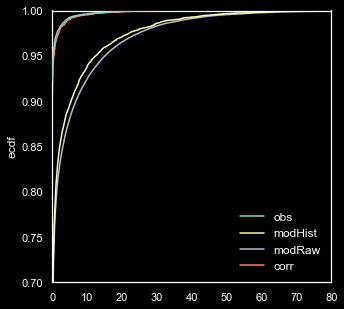

In [37]:
Data = {'obs': obs,
        'modHist': modHist,
        'modRaw': modRaw,
        'corr': corr}

fig, ax = plt.subplots(figsize=(5, 5), sharey=True)

for z, key in enumerate(Data):
    data = np.sort(Data[key])
    # ajustar la función de distribución empírica (ECDF) de los datos del modelo
    ecdf = ECDF(data)#>=0
    ax.plot(data, ecdf(data), lw=1.5, label=key, zorder=3-z)
    # plt.scatter(modRaw, qRaw, s=.5)
    ax.set(xlim=(0, 80), ylim=(.7, 1), ylabel=('ecdf'))

ax.grid(False)
ax.legend(loc=4, fontsize=12);

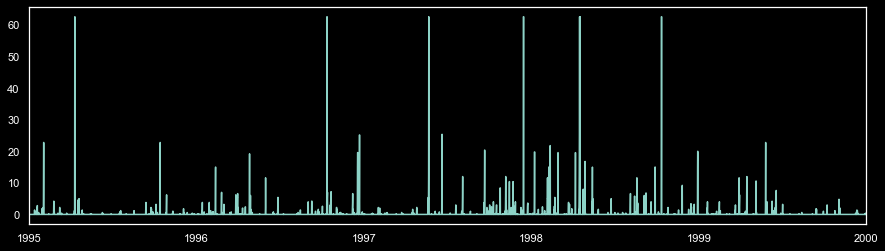

In [28]:
corr = pd.Series(corr, raw.index)

plt.figure(figsize=(15, 4))
plt.plot(corr)
plt.xlim('1995', '2000')
plt.grid(False);

In [30]:
# máximo de la serie
obs.max() * delta_max

62.6575937946127

El método _empirical quantile mapping_ tiene un serio problema: <font color='indianred'>todos los picos tienen el mismo valor</font>.